**TÍTULO**: Preprocessing          
**AUTOR**: Alexandre Saback  
**HISTÓRICO**: 
 - 12/2024: Criado durante o desenvolvimento da primeira tarefa AD-01.

**RESUMO**: 
> O objetivo dessa exploração inicial é verificar e validar os dados existentes, assim como, selecionar um conjunto inicial 
> de dados que podem ser utilizados futuramente em outras análises.

**DADOS DE ENTRADA**: 
- /sources/raw/*

**DADOS DE SAÍDA**:
- /sources/processed/*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from os.path import join
import re
import math
import geopandas as gpd

# Funções Úteis

In [2]:
import os

def match_file_names(
    path: str,
    codes: list[str] = None,
    start_year: int = 2009,
    end_year: int = 2024):

    """
    Procura por arquivos CSV que contenham algum dos códigos especificados em seus nomes
    e que estejam dentro do intervalo de anos permitido.

    Parâmetros
    ----------
    path : str
        Caminho inicial para a busca.
    codes : list[str], opcional
        Lista de códigos que devem estar nos nomes dos arquivos.
    start_year : int, opcional
        Ano inicial do filtro de diretórios (inclusivo). Default = 2009.
    end_year : int, opcional
        Ano final do filtro de diretórios (inclusivo). Default = 2024.

    Retorno
    -------
    matched_files : list[str]
        Uma lista com os caminhos dos arquivos que atendem aos critérios.
    """

    matched_files = []
    codes_set = set(codes) if codes else None  # Usa um set para busca eficiente

    for root, _, files in os.walk(path):
        # Obtém o último diretório no caminho (o ano)
        last_folder = os.path.basename(root)

        # Verifica se o diretório representa um ano válido dentro do intervalo desejado
        if last_folder.isdigit():
            year = int(last_folder)
            if year < start_year or year > end_year:
                continue  # Ignora diretórios fora do intervalo

        for file in files:
            if file.lower().endswith(".csv"):
                # Verifica se algum código está no nome do arquivo
                if codes_set is None or any(code in file for code in codes_set):
                    matched_files.append(os.path.join(root, file))

    return matched_files


In [3]:
def extract_code(filepath: str):

    """Extrai o código (A###) do nome do arquivo a partir do caminho completo."""

    filename = os.path.basename(filepath)  # Pega apenas o nome do arquivo
    match = re.search(r"A\d{3}", filename)

    return match.group(0) if match else None

In [4]:
def replace_comma(value):

    """
    Substitui vírgulas por pontos em valores numéricos para que o pandas possa ler como float.

    Parâmetros
    ----------
    value : any
        Valor a ser modificado.

    Retorno
    -------
    any
        Valor modificado.
    """

    if isinstance(value, str): 
        return pd.to_numeric(value.replace(",", "."), errors='coerce') 
    
    return value 

In [5]:
def read_files(
    file_names: list[str],
    encoding: str = "utf8",
    delimiter: str = ","):

    """
    Lê arquivos CSV da lista de nomes de arquivos fornecida e retorna uma lista de DataFrames do pandas.

    Parâmetros
    ----------
    file_names : list[str]
        Lista de caminhos de arquivos a serem lidos.
    encoding : str, opcional
        Encoding a ser usado ao ler os arquivos. O padrão é "utf8".
    delimiter : str, opcional
        Delimitador a ser usado ao ler os arquivos. O padrão é ",".

    Retorno
    -------
    df_list : list[pd.DataFrame]
        Uma lista de DataFrames do pandas lidos dos arquivos especificados.
    """

    df_list = []
    for file_name in file_names:

        with open(file_name, "r", encoding=encoding) as file:
            lines = file.readlines()
        
        header_index = next(i for i, line in enumerate(lines) if line.startswith("Data") or line.startswith("DATA ("))
        print(lines[12])

        try:
            df = pd.read_csv(
                file_name, 
                skiprows=header_index,
                encoding=encoding, 
                delimiter=delimiter,
                decimal=",",
                on_bad_lines="skip",
                skip_blank_lines=True)
            
            if "Unnamed: 19" in df.columns.tolist():
                df = df.drop(columns=["Unnamed: 19"])

            df["Hora UTC"] = df["Hora UTC"].str.replace(" UTC", "")
            df["Datetime"] = pd.to_datetime(df["Data"] + " " + df["Hora UTC"], format="%Y/%m/%d %H%M")

            station_code = extract_code(filepath=file_name)

            df["Estacao"] = station_code

            df.rename(columns={"RADIACAO GLOBAL (KJ/m²)": "RADIACAO GLOBAL (Kj/m²)"}, inplace=True)

            for col in [col for col in df.columns if col not in ["Data", "Hora UTC", "Datetime"]]:
                df[col] = df[col].apply(replace_comma)

            df_list.append(df)
        except Exception as e:
            print(f"Exception {e} on {file_name}")
            raise

        
    return df_list

In [6]:
def plot_grouped_data(
    df: pd.DataFrame,
    group_col: str,
    value_col: str,
    xticks_rotation: int = 0,
    apply_log: bool = False):

    """
    Plota dados agrupados do DataFrame fornecido.

    Parâmetros
    ----------
    df: pd.DataFrame
        Os dados a serem plotados.
    group_col: str
        O nome da coluna a ser agrupada.
    value_col: str
        O nome da coluna para os valores a serem plotados.
    bar: bool, opcional
        Se True, plota gráficos de barras. O padrão é False.
    x_axis: bool, opcional
        Se True, plota no eixo x. O padrão é False.
    hue_col: str, opcional
        O nome da coluna para o hue. O padrão é None.
    xticks_rotation: int, opcional
        Ângulo de rotação para x-ticks. O padrão é 0.
    apply_log: bool, opcional
        Se True, aplica transformação de log aos valores. O padrão é False.
    """


    if apply_log:
        df[value_col] = np.log(df[value_col])

    grouped_data = list(df.groupby(by=group_col))

    num_plots = len(grouped_data)
    num_cols = 2
    num_rows = math.ceil(num_plots / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 6 * num_rows), sharey=True)
    axes = axes.reshape(-1, num_cols) if num_rows > 1 else [axes]

    for idx, (group, df_values) in enumerate(grouped_data):
        row, col = divmod(idx, num_cols)
        ax = axes[row][col]
        
        sns.lineplot(df_values[value_col], ax=ax)
        
        plt.suptitle(value_col)
        ax.set_title(group)
        plt.xticks(rotation=xticks_rotation)

    for idx in range(num_plots, num_rows * num_cols):
        row, col = divmod(idx, num_cols)
        fig.delaxes(axes[row][col])

    plt.tight_layout()
    plt.show()

# Coleta de Dados

In [7]:
MODULE_PATH = Path().absolute().parent
DATA_PATH = join(MODULE_PATH, "sources/raw")

url_municipios_ibge = "https://raw.githubusercontent.com/kelvins/Municipios-Brasileiros/main/csv/municipios.csv"
url_estados_ibge = "https://raw.githubusercontent.com/kelvins/municipios-brasileiros/refs/heads/main/csv/estados.csv"

In [8]:
stations = pd.read_csv(join(DATA_PATH, "basedosdados/br_inmet_bdmep_estacao.csv"), dtype={"id_municipio": str})
df_municipios = pd.read_csv(url_municipios_ibge, usecols=["codigo_ibge", "codigo_uf"], dtype={"codigo_ibge": str})
df_estados = pd.read_csv(url_estados_ibge, usecols=["codigo_uf", "uf", "regiao"],  dtype={"codigo_ibge": str})

# Pré-Processamento

In [9]:
df_municipios.rename(columns={"codigo_ibge": "id_municipio"}, inplace=True)

In [10]:
stations = stations.merge(df_municipios, on="id_municipio", how="left").merge(df_estados, on="codigo_uf", how="left")

In [11]:
stations["data_fundacao"] = pd.to_datetime(stations["data_fundacao"], errors="coerce")

# Definindo Estações Para Coleta de Dados

In [12]:
selected_stations = stations.loc[
    ~stations["id_estacao"].isin(["A101", "A308", "A404", "A410", "A506", "A706", "A708"])].sort_values(
        by="data_fundacao").groupby("regiao").head(20)

In [13]:
selected_stations

,id_municipio,id_estacao,estacao,data_fundacao,latitude,longitude,altitude,codigo_uf,uf,regiao
0,5300108,A001,Brasilia,2000-05-07,-15.789444,-47.925833,1160.96,53.0,DF,Centro-Oeste
120,2927408,A401,Salvador,2000-05-13,-13.005515,-38.505760,47.56,29.0,BA,Nordeste
425,3305554,A601,Seropedica-Ecologia Agricola,2000-05-24,-22.757778,-43.684722,35.00,33.0,RJ,Sudeste
519,4314902,A801,Porto Alegre,2000-09-22,-30.053611,-51.174722,41.18,43.0,RS,Sul
6,5213806,A003,Morrinhos,2001-05-25,-17.745066,-49.101698,751.09,52.0,GO,Centro-Oeste
...,...,...,...,...,...,...,...,...,...,...
301,1508100,A229,Tucurui,2008-03-01,-3.822778,-49.675000,137.94,15.0,PA,Norte
298,1501709,A226,Braganca,2008-03-11,-1.047222,-46.785833,41.00,15.0,PA,Norte
272,1302504,A119,Manacapuru,2008-04-10,-3.294722,-60.628333,36.57,13.0,AM,Norte
276,1303403,A123,Parintins,2008-04-11,-2.639167,-56.756111,18.72,13.0,AM,Norte


## Visualizando Estações

In [14]:
region_colors = {
    "Norte": "green",
    "Nordeste": "blue",
    "Centro-Oeste": "orange",
    "Sudeste": "red",
    "Sul": "purple"
}

selected_stations["cor"] = selected_stations["regiao"].map(region_colors)

In [15]:
brazil_map = gpd.read_file(f"{MODULE_PATH}/misc/BR_UF_2022.shp")

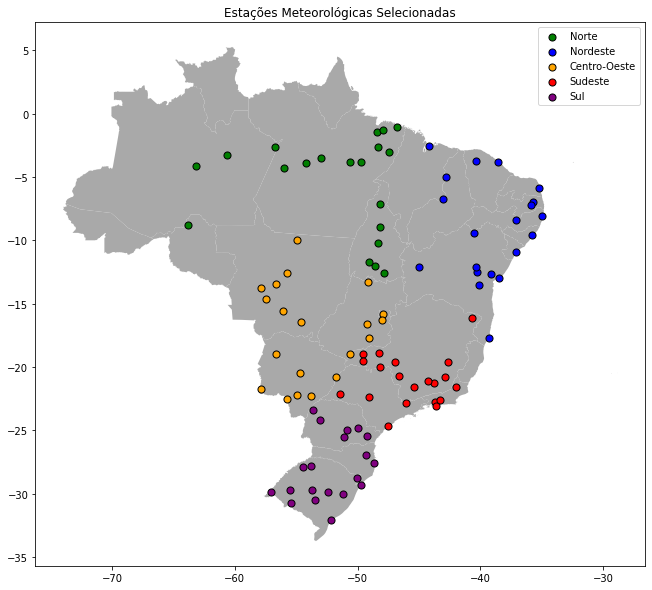

In [16]:
gdf_estacoes = gpd.GeoDataFrame(
    selected_stations,
    geometry=gpd.points_from_xy(selected_stations.longitude, selected_stations.latitude),
    # crs="epsg:4326"
)

fig, ax = plt.subplots(figsize=(20, 10))
brazil_map.plot(ax=ax, color="darkgrey")
# gdf_estacoes.plot(ax=ax, color="red", markersize=50, label="Estações INMET")

for region, cor in region_colors.items():
    subset = gdf_estacoes[gdf_estacoes["regiao"] == region]
    ax.scatter(subset.longitude, subset.latitude, color=cor, label=region, s=50, edgecolors="black")


# for i, row in selected_stations.iterrows():
#     offset = 0.2 if i % 2 == 0 else -0.2  # Alternar deslocamento para evitar sobreposição
#     ax.text(row.longitude + offset, row.latitude + offset, row.estacao, fontsize=8, ha='right', color='black')

ax.set_title("Estações Meteorológicas Selecionadas")
plt.legend()
plt.show()

## Período Mínimo de Coleta

In [17]:
selected_stations["data_fundacao"].max()

Timestamp('2008-04-12 00:00:00')

## Coleta de Dados de Estações

In [18]:
data_2009_2013 = pd.read_csv(join(DATA_PATH, "basedosdados/2009_2013.csv"))
data_2014_2018 = pd.read_csv(join(DATA_PATH, "basedosdados/2014_2018.csv"))
data_2019_2024 = pd.read_csv(join(DATA_PATH, "basedosdados/2019_2024.csv"))

In [19]:
complete_df = pd.concat([data_2009_2013, data_2014_2018, data_2019_2024])

In [20]:
complete_df["data"] = pd.to_datetime(complete_df["data"])

# Checando a Estrutura dos Dados

## Valores Nulos

In [21]:
station_percentual_nans = complete_df[complete_df.columns[4:]].isna().groupby(complete_df["id_estacao"]).mean().mean(axis=1).sort_values(ascending=False) * 100
station_percentual_nans = station_percentual_nans.reset_index(name="NaNs")

In [22]:
bins = [0, 10, 20, 30, 100]
labels = ["≤ 10%", "≤ 20%", "≤ 30%", "> 30%"]

categories = pd.cut(station_percentual_nans["NaNs"], bins=bins, labels=labels, right=True)

In [23]:
station_percentual_nans["Categoria"] = categories.values.tolist()

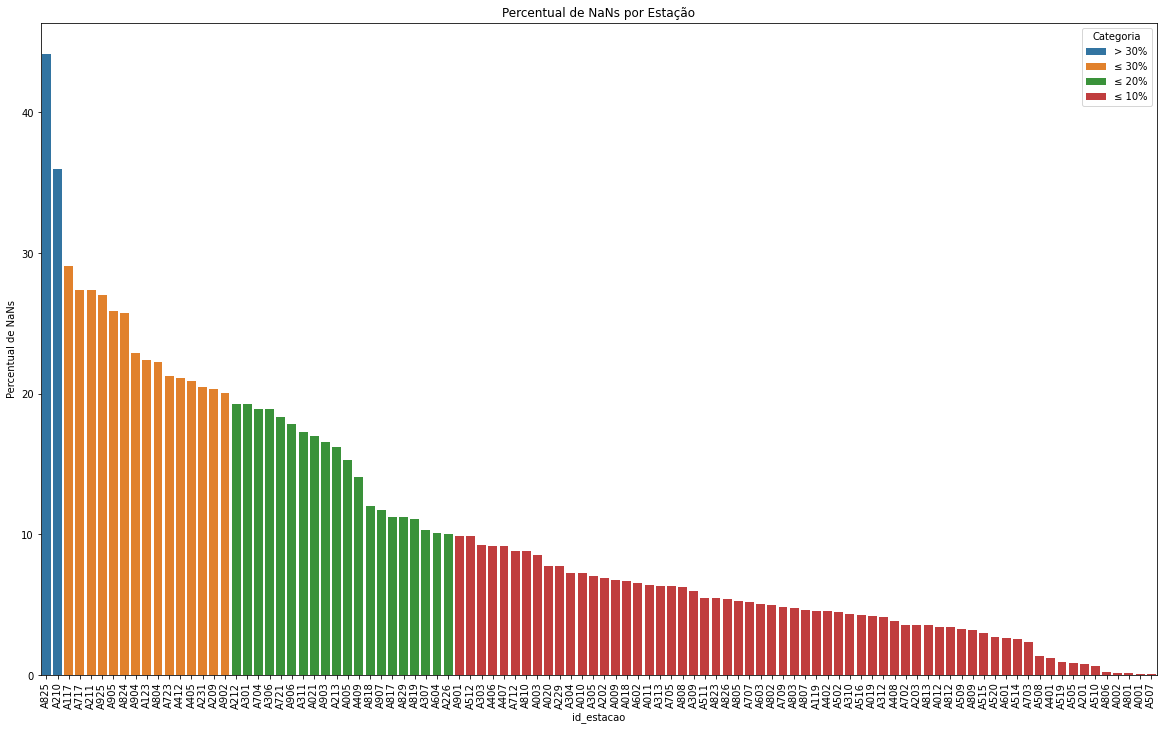

In [24]:
fig, ax = plt.subplots(figsize=(20,12))
sns.barplot(
    x=station_percentual_nans["id_estacao"], 
    y=station_percentual_nans["NaNs"], 
    hue=station_percentual_nans["Categoria"])
plt.xticks(rotation=90)
plt.ylabel("Percentual de NaNs")
plt.title("Percentual de NaNs por Estação")
plt.show()

In [25]:
station_percentual_nans["Categoria"].value_counts()

Categoria
≤ 10%    63
≤ 20%    20
≤ 30%    15
> 30%     2
Name: count, dtype: int64

# Adição de Dados dos Fenômenos El Niño e La Niña

## Pré-Processamento e Criação do Conjunto de Dados

In [26]:
# https://psl.noaa.gov/data/correlation/nina34.anom.data
nino_data = """
2000  -1.77  -1.55  -0.98  -0.87  -0.86  -0.79  -0.67  -0.49  -0.52  -0.70  -0.79  -0.92
2001  -0.73  -0.63  -0.48  -0.49  -0.34  -0.19  -0.04  -0.05  -0.20  -0.14  -0.37  -0.41
2002  -0.15  -0.04   0.01   0.02   0.31   0.72   0.74   0.87   1.09   1.25   1.47   1.37
2003   0.60   0.64   0.36  -0.14  -0.61  -0.29   0.21   0.26   0.27   0.42   0.33   0.43
2004   0.27   0.23   0.12   0.07   0.06   0.13   0.49   0.76   0.81   0.73   0.66   0.74
2005   0.66   0.36   0.45   0.26   0.30   0.04  -0.23  -0.05  -0.04  -0.06  -0.59  -0.92
2006  -0.91  -0.67  -0.71  -0.32  -0.09   0.00   0.01   0.31   0.60   0.70   0.99   1.14
2007   0.70   0.13  -0.18  -0.32  -0.47  -0.35  -0.59  -0.72  -1.11  -1.39  -1.54  -1.58
2008  -1.68  -1.67  -1.21  -0.99  -0.84  -0.68  -0.30  -0.13  -0.25  -0.35  -0.46  -0.86
2009  -0.89  -0.79  -0.69  -0.35   0.06   0.31   0.48   0.56   0.68   0.89   1.46   1.74
2010   1.52   1.25   0.90   0.38  -0.22  -0.69  -1.07  -1.39  -1.60  -1.69  -1.64  -1.60
2011  -1.54  -1.11  -0.93  -0.77  -0.52  -0.38  -0.43  -0.65  -0.80  -1.05  -1.19  -1.06
2012  -0.87  -0.67  -0.61  -0.50  -0.32   0.02   0.25   0.47   0.38   0.26   0.16  -0.25
2013  -0.53  -0.52  -0.25  -0.25  -0.40  -0.42  -0.39  -0.38  -0.18  -0.20  -0.14  -0.17
2014  -0.49  -0.62  -0.28   0.08   0.32   0.23  -0.06  -0.03   0.29   0.44   0.75   0.71
2015   0.51   0.42   0.47   0.70   0.92   1.18   1.46   1.93   2.21   2.36   2.72   2.66
2016   2.57   2.26   1.62   0.91   0.30  -0.03  -0.48  -0.58  -0.58  -0.74  -0.76  -0.50
2017  -0.43  -0.08   0.03   0.22   0.37   0.34   0.25  -0.16  -0.43  -0.56  -0.97  -0.98
2018  -0.98  -0.78  -0.80  -0.51  -0.20   0.04   0.12   0.09   0.47   0.90   0.90   0.89
2019   0.65   0.71   0.81   0.62   0.55   0.45   0.35   0.04   0.03   0.48   0.52   0.52
2020   0.60   0.37   0.48   0.36  -0.27  -0.34  -0.30  -0.59  -0.83  -1.26  -1.42  -1.15
2021  -1.00  -1.00  -0.80  -0.72  -0.46  -0.28  -0.39  -0.53  -0.55  -0.94  -0.94  -1.06
2022  -0.94  -0.89  -0.97  -1.11  -1.11  -0.75  -0.69  -0.97  -1.07  -0.99  -0.90  -0.85
2023  -0.72  -0.46  -0.11   0.14   0.46   0.84   1.02   1.35   1.60   1.72   2.02   2.03
2024   1.81   1.52   1.13   0.77   0.23   0.17   0.04  -0.12  -0.26  -0.27  -0.25  -0.60
"""

In [27]:
lines = nino_data.strip().split("\n")

formatted_data = []
for line in lines:
    values = line.split()
    year = int(values[0])

    for month, value in enumerate(values[1:], start=1):
        formatted_data.append([year, month, float(value)])

nino_df = pd.DataFrame(formatted_data, columns=["ano", "mes", "valor"])
nino_df["categoria"] = nino_df["valor"].apply(lambda x: "El Ninõ" if x >= 0.5 else ("La Ninã" if x <= -0.5 else "Neutro"))

In [28]:
nino_df

,ano,mes,valor,categoria
0,2000,1,-1.77,La Ninã
1,2000,2,-1.55,La Ninã
2,2000,3,-0.98,La Ninã
3,2000,4,-0.87,La Ninã
4,2000,5,-0.86,La Ninã
...,...,...,...,...
295,2024,8,-0.12,Neutro
296,2024,9,-0.26,Neutro
297,2024,10,-0.27,Neutro
298,2024,11,-0.25,Neutro


## Exportação de Dados

In [29]:
nino_df.to_csv(f"{MODULE_PATH}/sources/processed/nino_3.4_categorias.csv", index=False)

## Unificando Conjuntos de Dados

In [30]:
complete_df = complete_df.merge(nino_df[["ano", "mes", "categoria"]], how="left", on=["ano", "mes"])

### Adicionando Dummies

In [31]:
complete_df = pd.get_dummies(data=complete_df, columns=["categoria"], drop_first=True, dtype=int)

# Adição de Dados da Qualidade do Ar

## Coleta de Dados

In [32]:
air_quality_data = pd.read_csv(
    join(DATA_PATH, "iema/Avaliação diária da qualidade do ar_data.csv"),
    sep=";").iloc[:, :-1]

In [33]:
air_quality_data["Data"] = pd.to_datetime(air_quality_data["Data"], format="%d/%m/%Y")

## Agregação Pela Média

In [34]:
air_quality_mean_data = air_quality_data.groupby(by=["Data", "Poluente"])["NumeroIQAR"].mean().reset_index()

## Classificação da Qualidade do Ar

In [35]:
iqar_thresholds = {
    "MP10": [50, 100, 150, 250],  # µg/m³ (24h)
    "MP2.5": [25, 50, 75, 125],   # µg/m³ (24h)
    "O3": [100, 130, 160, 200],   # µg/m³ (8h)
    "CO": [9, 11, 13, 15],        # ppm (8h)
    "NO2": [200, 240, 320, 1130], # µg/m³ (1h)
    "SO2": [20, 40, 365, 800]     # µg/m³ (24h)
}

iqar_categories = ["Boa", "Moderada", "Ruim", "Muito Ruim", "Péssima"]

In [36]:
def classify_iqar(row):

    poluente = row["Poluente"]
    valor = row["NumeroIQAR"]
    
    if poluente in iqar_thresholds:
        limites = iqar_thresholds[poluente]

        for i, limite in enumerate(limites):
            if valor <= limite:
                return iqar_categories[i]
        return "Péssima"  # Acima do maior limite
    return "Desconhecido"

In [37]:
air_quality_mean_data["Classificacao"] = air_quality_mean_data.apply(classify_iqar, axis=1)

In [38]:
air_quality_mean_data["Classificacao"].value_counts()

Classificacao
Boa         14067
Moderada      531
Ruim           12
Name: count, dtype: int64

## Pivot dos Dados

In [39]:
air_quality_pivot_data = air_quality_mean_data.pivot_table(index="Data", columns="Poluente", values="Classificacao", aggfunc="first")
air_quality_pivot_data = air_quality_pivot_data.reset_index()
air_quality_pivot_data.columns.name = None

In [40]:
air_quality_pivot_data.head()

,Data,CO,MP10,MP2.5,O3,SO2
0,2015-01-01,Boa,Boa,Boa,Boa,Boa
1,2015-01-02,Boa,Boa,Boa,Boa,Boa
2,2015-01-03,Boa,Boa,Boa,Boa,Boa
3,2015-01-04,Boa,Boa,Boa,Boa,Boa
4,2015-01-05,Boa,Boa,Boa,Boa,Boa


## Unificando Conjuntos de Dados

In [41]:
complete_df.merge(air_quality_pivot_data.rename(columns={"Data": "data"}), how="left", on=["data"])

,ano,mes,data,id_estacao,precipitacao_total_media,pressao_atm_hora_media,pressao_atm_max_media,pressao_atm_min_media,radiacao_global_media,temperatura_bulbo_hora_media,...,umidade_rel_min_media,vento_rajada_max_media,vento_velocidade_media,categoria_La Ninã,categoria_Neutro,CO,MP10,MP2.5,O3,SO2
0,2009,1,2009-01-01,A001,0.908333,885.945833,886.241667,885.662500,1736.800000,23.229167,...,69.291667,4.787500,1.904167,1,0,NaN,NaN,NaN,NaN,NaN
1,2009,1,2009-01-01,A002,0.009524,931.276190,931.628571,930.971429,1080.338462,24.509524,...,72.333333,3.661905,1.214286,1,0,NaN,NaN,NaN,NaN,NaN
2,2009,1,2009-01-01,A003,0.100000,928.716667,929.016667,928.458333,832.271429,23.120833,...,80.250000,3.175000,1.066667,1,0,NaN,NaN,NaN,NaN,NaN
3,2009,1,2009-01-01,A009,0.000000,977.133333,977.454167,976.812500,1729.523077,28.616667,...,64.250000,3.675000,1.408333,1,0,NaN,NaN,NaN,NaN,NaN
4,2009,1,2009-01-01,A010,0.000000,977.300000,977.595833,977.000000,1785.792857,28.075000,...,65.250000,0.529167,0.000000,1,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561110,2024,7,2024-07-31,A904,0.000000,971.545833,971.800000,971.295833,1383.866667,28.204167,...,37.000000,4.845833,2.300000,0,1,NaN,NaN,NaN,NaN,NaN
561111,2024,7,2024-07-31,A905,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN
561112,2024,7,2024-07-31,A906,NaN,981.341667,981.579167,981.079167,1299.116667,26.741667,...,51.541667,2.525000,0.566667,0,1,NaN,NaN,NaN,NaN,NaN
561113,2024,7,2024-07-31,A907,0.000000,982.116667,982.416667,981.900000,765.120833,25.216667,...,55.250000,3.275000,1.187500,0,1,NaN,NaN,NaN,NaN,NaN
